# Globular Cluster Member Identification: NGC 6397
NGC 6397 is the second closest globular cluster to Earth (second to M4).  Similar to our exploration of M4 using Gaia, we're going to make use of a catalog of confidently identified stellar members of the cluster to train classifiers capable of making such classifications from Gaia observations.

First we'll download the necessary data.  The catalog was originally pulled from [here](http://cdsarc.u-strasbg.fr/ftp/J/A+A/616/A12/), and can be found in `data/NGC6397-1.dat`.

From the Gaia archive we'll pull all objects in a 2 deg x 1.5 deg box centered on the cluster.  The query used is below, which was used to generate `data/gaia-NGC6397-neighborhood.csv`.

```sql
SELECT TOP 500000 gaia_source.source_id,gaia_source.ra,gaia_source.dec,gaia_source.parallax,gaia_source.parallax_error,gaia_source.pm,gaia_source.pmra,gaia_source.pmra_error,gaia_source.pmdec,gaia_source.pmdec_error,gaia_source.phot_g_mean_mag,gaia_source.phot_bp_mean_mag,gaia_source.phot_rp_mean_mag,gaia_source.bp_rp,gaia_source.radial_velocity,gaia_source.radial_velocity_error
FROM gaiadr3.gaia_source 
WHERE 
CONTAINS(
	POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),
	BOX('ICRS',265.17,-53.68,2,1.5)
)=1
```

# 1. Classification

1. Load the data and cross match the confident cluster members with the larger Gaia sample.

In [284]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [285]:
Cluster_df = pd.read_fwf('C:/Users/rabin/sci-comp-ii-fall24/Working/final_NGC-6397-project/data/NGC6397-1.dat')
Cluster_df

,5921543639477589120,264.16385,-53.98070,19.941
0,5921539825546549120,264.25211,-54.06070,19.086
1,5921542265088057472,264.20510,-53.94871,18.252
2,5921539585011442304,264.33958,-54.03101,19.001
3,5921530887707179136,264.28545,-54.20321,17.558
4,5921543192800960640,264.19193,-54.01173,19.580
...,...,...,...,...
22110,5921705714351627520,265.42989,-53.58280,19.074
22111,5921744605276401152,265.16443,-53.75388,13.111
22112,5921694478712334080,265.40734,-53.92330,19.691
22113,5921744403412609792,265.24265,-53.75581,18.204


In [286]:
# Assignning names manually because they don't have it.
Cluster_df.columns = ['source_id', 'ra', 'dec', 'phot_g_mean_mag']

# Verify the column names
print(Cluster_df.head())

             source_id         ra       dec  phot_g_mean_mag
0  5921539825546549120  264.25211 -54.06070           19.086
1  5921542265088057472  264.20510 -53.94871           18.252
2  5921539585011442304  264.33958 -54.03101           19.001
3  5921530887707179136  264.28545 -54.20321           17.558
4  5921543192800960640  264.19193 -54.01173           19.580


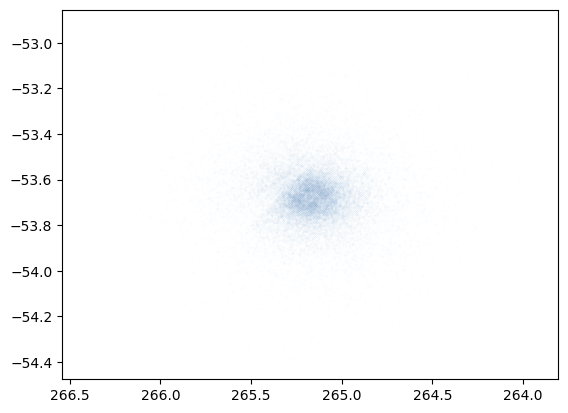

In [287]:
plt.scatter(Cluster_df.ra, Cluster_df.dec, s=0.0001)
plt.gca().invert_xaxis()

In [288]:
gaia_df = pd.read_csv('C:/Users/rabin/sci-comp-ii-fall24/Working/final_NGC-6397-project/data/gaia-NGC6397-neighborhood.csv')
gaia_df

,source_id,ra,dec,parallax,parallax_error,pm,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,radial_velocity,radial_velocity_error
0,5921580885428432512,264.170005,-53.499365,1.971942,1.147845,6.570742,-3.427931,1.380354,-5.605706,1.024108,20.746939,21.251717,20.174982,1.076734,NaN,NaN
1,5921543020999334144,264.170011,-54.034645,2.198161,1.562906,6.002902,-3.379062,1.845994,-4.961529,1.303942,20.789845,21.254570,19.668575,1.585995,NaN,NaN
2,5921569649783611008,264.170013,-53.799463,-0.357875,0.412176,5.155796,-3.728736,0.449804,-3.560725,0.369994,19.918226,20.593761,19.042880,1.550882,NaN,NaN
3,5921435028337797120,264.170019,-54.384088,1.181531,0.547741,13.745267,3.386150,0.530489,-13.321649,0.433790,20.157225,21.535680,18.972637,2.563044,NaN,NaN
4,5921966951438882816,264.170023,-53.163328,0.236054,0.413523,2.402006,-1.183284,0.382022,-2.090328,0.300960,19.705696,20.310032,19.047543,1.262489,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296551,5921716434605479424,266.169944,-53.608514,-0.867402,1.485600,9.257812,-1.645777,2.405371,-9.110352,1.666693,20.762312,21.288015,20.142715,1.145300,NaN,NaN
296552,5921718083862387456,266.169988,-53.554392,0.024822,0.731553,5.468407,-2.267840,0.808585,-4.975980,0.607609,20.413818,20.934456,19.738728,1.195728,NaN,NaN
296553,5921671079738396800,266.169995,-54.264224,4.664465,2.357308,13.306737,-5.366040,1.640666,-12.176816,1.550591,20.657871,NaN,NaN,NaN,NaN,NaN
296554,5921813019815200128,266.169997,-53.444160,1.875253,0.585601,9.939879,-3.430568,0.540236,-9.329116,0.426569,20.135847,20.743576,18.981106,1.762470,NaN,NaN


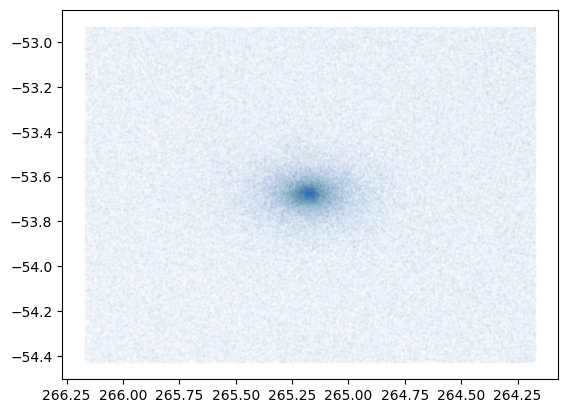

In [289]:
plt.scatter(gaia_df.ra, gaia_df.dec, s=0.0001)
plt.gca().invert_xaxis()

In [290]:
#cross-matching between the two data sets. 
# construct a selection array that selects for the cluster members identified in the cluster mini-catalog.

Cluster_sel = gaia_df['source_id'].isin(Cluster_df.source_id)
print(np.count_nonzero(Cluster_sel))

21772


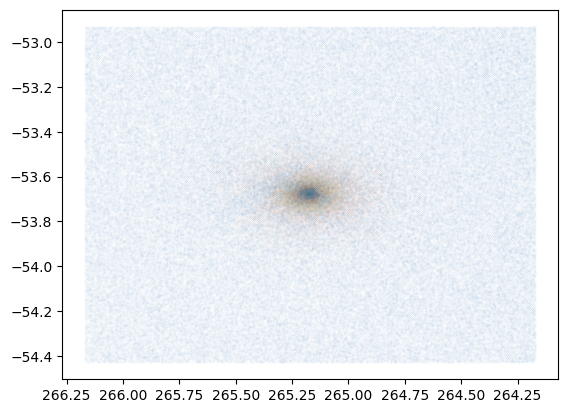

In [291]:
plt.scatter(gaia_df.ra[~Cluster_sel], gaia_df.dec[~Cluster_sel], s=0.0001)
plt.scatter(gaia_df.ra[Cluster_sel], gaia_df.dec[Cluster_sel], s=0.0001)
plt.gca().invert_xaxis()

2. Explore the data, sticking to position (e.g., ra, dec, etc.) and velocity (e.g. pm, etc.) measurements for now.  Are there particular observed quantities that seem useful for distinguishing cluster members from background stars?  Be sure to include lots of figures and discussion!

In [292]:
#Reminder to myself: 
#Gaia dataset for analysis of all stars in the region.
#Cluster dataset to identify true cluster members and build classifier.
#Cross-Match dataset for validation of results.

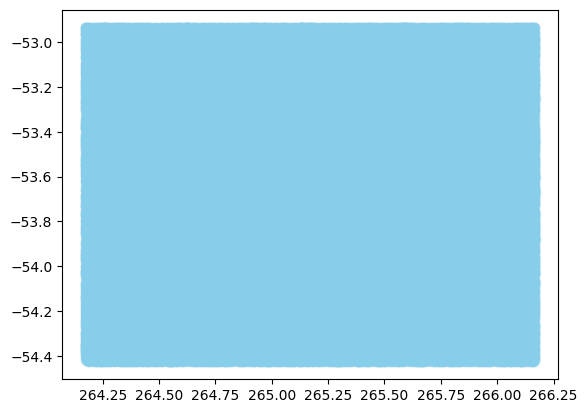

In [293]:
#plt.scatter(Cluster_df['ra'], Cluster_df['dec'], color='red', alpha=0.2)
plt.scatter(gaia_df['ra'], gaia_df['dec'], color='skyblue', alpha=0.2)
plt.show()

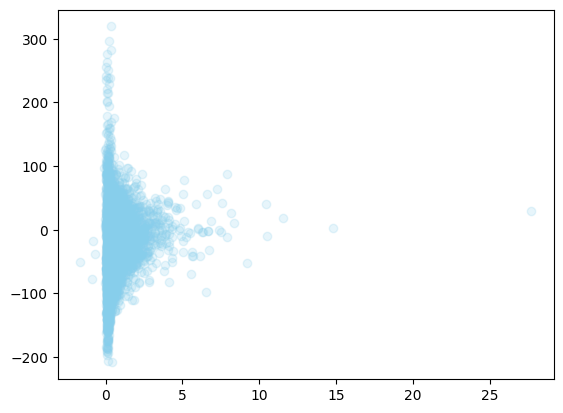

In [294]:
#plt.scatter(Cluster_df['ra'], Cluster_df['dec'], color='red', alpha=0.2)
plt.scatter(gaia_df['parallax'], gaia_df['radial_velocity'], color='skyblue', alpha=0.2)
plt.show()

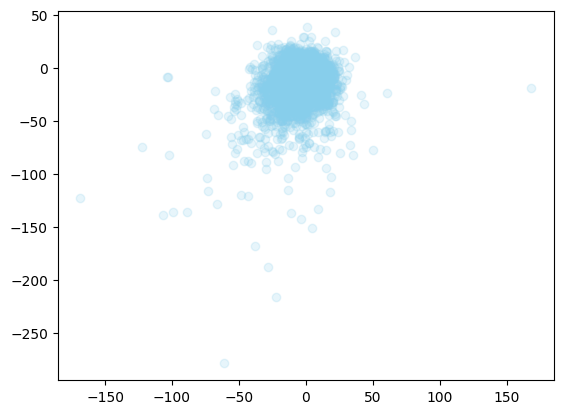

In [295]:
#plt.scatter(Cluster_df['ra'], Cluster_df['dec'], color='red', alpha=0.2)
plt.scatter(gaia_df['pmra'], gaia_df['pmdec'], color='skyblue', alpha=0.2)
plt.show()

The scattered plot of pmra and pmdec is more clear because stars in cluster are bounded by garvitational force we can detect them more easily compared to what I found in two other graph. In my opion this graph is good for future to distinguish memeber vs non memeber stars. Graph of radial velocity also have the same concept but doesnot look nice. I am suspecting that very first graph being just the coordinate in a specific part of the sky could not detect any cluster inside of it.

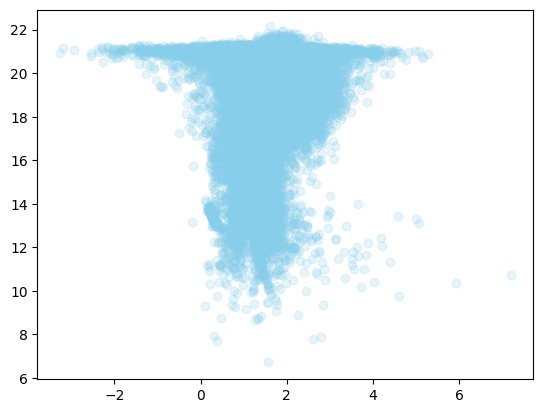

In [296]:
#plt.scatter(Cluster_df['ra'], Cluster_df['dec'], color='red', alpha=0.2)
plt.scatter(gaia_df['bp_rp'], gaia_df['phot_g_mean_mag'], color='skyblue', alpha=0.2)
plt.show()

This graph seems kind of good. As color of star is usually from its temperature and they might have large range of varieties so to accomodate all of them our graph is spreadout. 

3. Build and train a model (the type of model is up to you!) for classifying stars as members or non-members of NGC 6397 based on Gaia observations.  Be sure to show your process for building and improving the model.

In [297]:
gaia_df.columns

Index(['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'pm', 'pmra',
       'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'radial_velocity',
       'radial_velocity_error'],
      dtype='object')

In [298]:
params = ['pmra', 'pmdec'] #I found this feature good in my previous exploration.
X = np.array(gaia_df[params])
X.shape

(296556, 2)

In [299]:
np.count_nonzero(np.any(np.isnan(X), axis=1))

36346

In [300]:
nans = np.any(np.isnan(X), axis=1)
X = X[~nans]

n_classes = 2
y = Cluster_sel.astype(int)[~nans]

In [301]:
from sklearn.preprocessing import StandardScaler

In [302]:
transformer = StandardScaler()

X = transformer.fit_transform(X)

In [303]:
m = X.shape[0]
test_frac = 0.1
test_sel = np.random.choice([True, False], size=m, p=[test_frac, 1-test_frac])
X_tst = X[test_sel]
X_train = X[~test_sel]

y_tst = y[test_sel]
y_train = y[~test_sel]

In [304]:
import jax.numpy as jnp

In [305]:
X_train = jnp.array(X_train)
X_tst = jnp.array(X_tst)
y_train = jnp.array(y_train)
y_tst = jnp.array(y_tst)

In [306]:
batch_size = 64
n_batches = X_train.shape[0] // batch_size

X_train = X_train[:n_batches * batch_size].reshape((n_batches, batch_size, *X_train.shape[1:]))
y_train = y_train[:n_batches * batch_size].reshape((n_batches, batch_size, *y_train.shape[1:]))
X_train.shape, y_train.shape

((3663, 64, 2), (3663, 64))

In [307]:
import flax.linen as nn

In [308]:
n_classes = 2

class DenseClassifier(nn.Module):
    """A simple dense classifier."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(n_classes)(x)
        return x   #every x is different

In [309]:
import jax

In [310]:
dummy_input = jnp.ones((1, 2))
dnn = DenseClassifier()
print(dnn.tabulate(jax.random.PRNGKey(0), dummy_input))


                            DenseClassifier Summary                            
┌─────────┬─────────────────┬───────────────┬───────────────┬─────────────────┐
│ path    │ module          │ inputs        │ outputs       │ params          │
├─────────┼─────────────────┼───────────────┼───────────────┼─────────────────┤
│         │ DenseClassifier │ float32[1,2]  │ float32[1,2]  │                 │
├─────────┼─────────────────┼───────────────┼───────────────┼─────────────────┤
│ Dense_0 │ Dense           │ float32[1,2]  │ float32[1,10] │ bias:           │
│         │                 │               │               │ float32[10]     │
│         │                 │               │               │ kernel:         │
│         │                 │               │               │ float32[2,10]   │
│         │                 │               │               │                 │
│         │                 │               │               │ 30 (120 B)      │
├─────────┼─────────────────┼──────────

In [311]:
X_train.shape, y_train.shape

((3663, 64, 2), (3663, 64))

In [312]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

In [313]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   metrics: Metrics

In [314]:
def create_train_state(model, rng, learning_rate):
    params = model.init(rng, dummy_input)['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=tx,
        metrics=Metrics.empty())

In [315]:
@jax.jit
def train_step(state, batch, label):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [316]:
@jax.jit
def compute_metrics(*, state, batch, label):
    logits = state.apply_fn({'params': state.params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=label, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [317]:
init_rng = jax.random.PRNGKey(0)

learning_rate = 0.01

state = create_train_state(dnn, init_rng, learning_rate)
del init_rng 

In [318]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [319]:
n_epochs = 50

In [320]:
step = 0

for _ in range(n_epochs):
  for batch, label in zip(X_train, y_train):

    # Run optimization steps over training batches and compute batch metrics
    state = train_step(state, batch, label) # get updated train state (which contains the updated parameters)
    state = compute_metrics(state=state, batch=batch, label=label) # aggregate batch metrics

    if (step+1) % n_batches == 0: # one training epoch has passed
      for metric,value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
      state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

      # Compute metrics on the test set after each training epoch
      test_state = state
      test_state = compute_metrics(state=test_state, batch=X_tst, label=y_tst)

      for metric,value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

      print(f"train epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
      print(f"test epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")
    step += 1

train epoch: 1, loss: 0.08688148111104965, accuracy: 95.7428970336914
test epoch: 1, loss: 0.10205229371786118, accuracy: 93.00745391845703
train epoch: 2, loss: 0.08210970461368561, accuracy: 96.07050323486328
test epoch: 2, loss: 0.08285016566514969, accuracy: 96.12517547607422
train epoch: 3, loss: 0.08122050762176514, accuracy: 96.15581512451172
test epoch: 3, loss: 0.08949975669384003, accuracy: 95.30982971191406
train epoch: 4, loss: 0.08079075813293457, accuracy: 96.18354797363281
test epoch: 4, loss: 0.08190272003412247, accuracy: 96.04364013671875
train epoch: 5, loss: 0.08039211481809616, accuracy: 96.23003387451172
test epoch: 5, loss: 0.08382115513086319, accuracy: 95.91163635253906
train epoch: 6, loss: 0.08030252158641815, accuracy: 96.21681213378906
test epoch: 6, loss: 0.085957832634449, accuracy: 95.66703033447266
train epoch: 7, loss: 0.08012871444225311, accuracy: 96.22918701171875
test epoch: 7, loss: 0.094800665974617, accuracy: 94.6886215209961
train epoch: 8, los

4. How is your final model performing?  Could it have overfit the data?  Is it clear what the model learned?

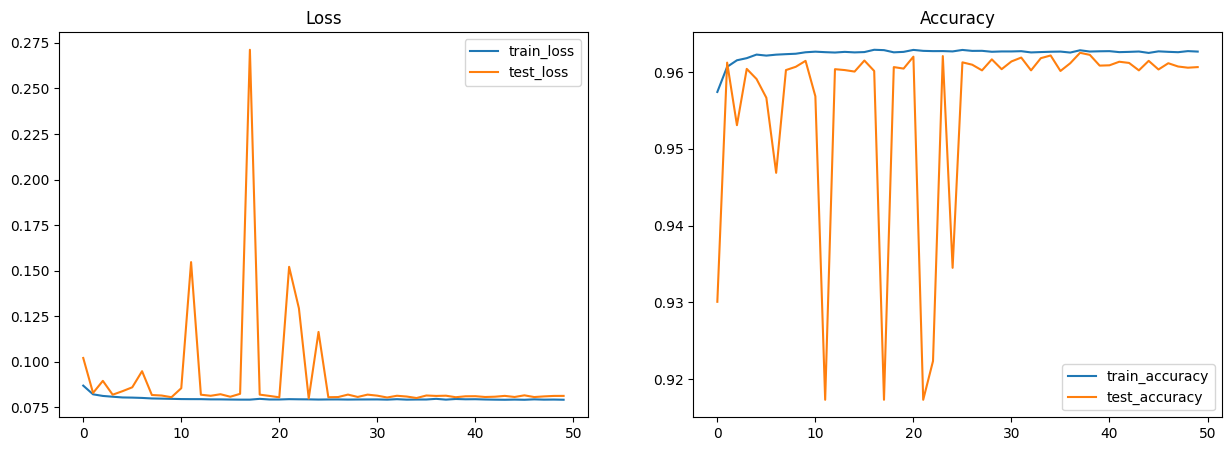

<Figure size 640x480 with 0 Axes>

In [321]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

Model seems good as training accuracy is 96% for trained data. To explain behaviour of test accuracy maybe we can claim that we are using proper motion. Training accuracy is higher than test accuracy so it indicates overfitting. Train loss and Test (validity) loss are  declining but increasing of test loss at the end shows overfitting of data. It seems like model learned patterned more from trained data instead of looking general data.

In [322]:
#to get visual of how classifier doing

@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, batch)
  return logits.argmax(axis=1)

pred = pred_step(state, X_tst)
pred

Array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

(array([23575.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2181.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

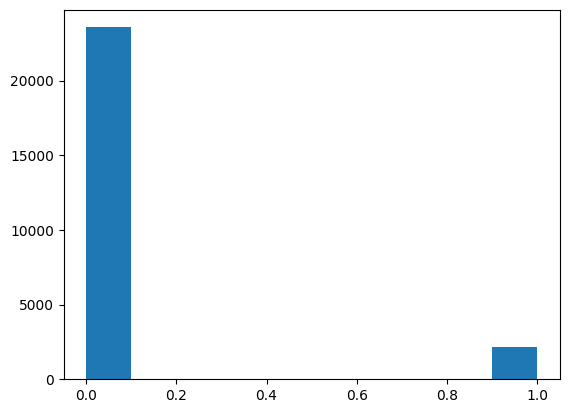

In [323]:
plt.hist(pred)

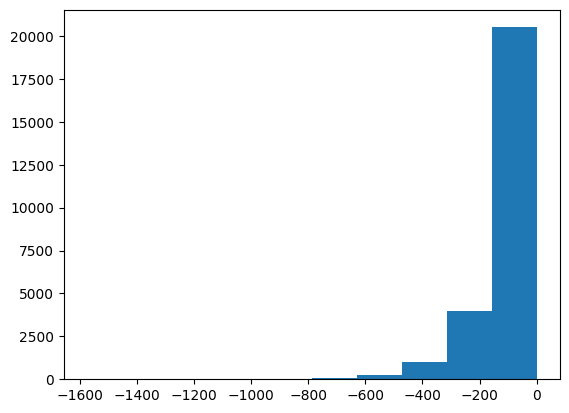

In [324]:
outputs = state.apply_fn({'params': state.params}, X_tst)
plt.hist(jnp.diff(outputs, axis=1).flatten());

None of them seems confidently associated with cluster (>0).

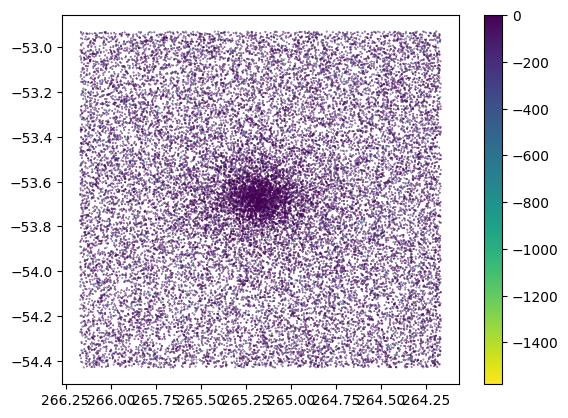

In [325]:
plt.scatter(gaia_df.ra[~nans][test_sel], gaia_df.dec[~nans][test_sel], c=jnp.diff(outputs, axis=1), s=.1, cmap='viridis_r')
plt.colorbar()

plt.gca().invert_xaxis()

<function matplotlib.pyplot.show(close=None, block=None)>

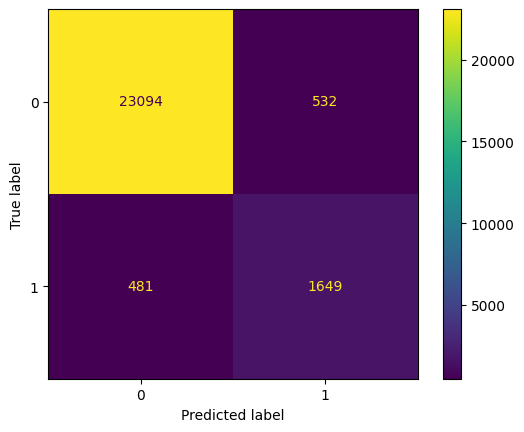

In [326]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

M = confusion_matrix(y_tst, pred)

Visualization = ConfusionMatrixDisplay(confusion_matrix=M)
Visualization.plot()
plt.show

5. Does your model find any new cluster member candidates?  If so, explore their properties.  Do they seem compelling?  Be sure to connect this discussion back to your response to 1.1.

In [327]:
new_members = X_tst[pred == 1]  # stars predicted as cluster members
print(new_members)


[[ 1.2086799 -1.6748306]
 [ 1.3337286 -1.7119305]
 [ 1.1626891 -1.7036444]
 ...
 [ 1.1907288 -1.6303443]
 [ 1.1651156 -1.745918 ]
 [ 1.2284812 -1.7158804]]


In [328]:
new_members_df = pd.DataFrame(new_members, columns=['pmra', 'pmdec'])

<function matplotlib.pyplot.show(close=None, block=None)>

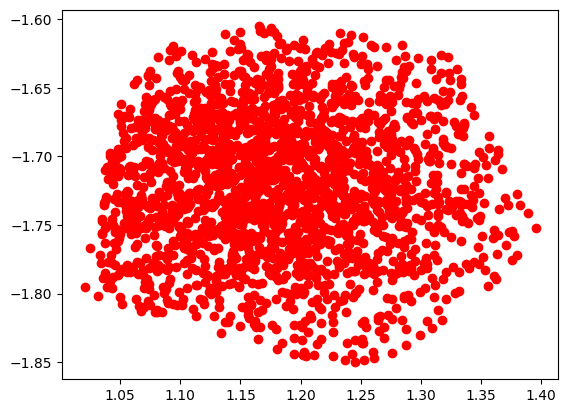

In [329]:
plt.scatter(new_members_df['pmra'], new_members_df['pmdec'], color='red')
plt.show

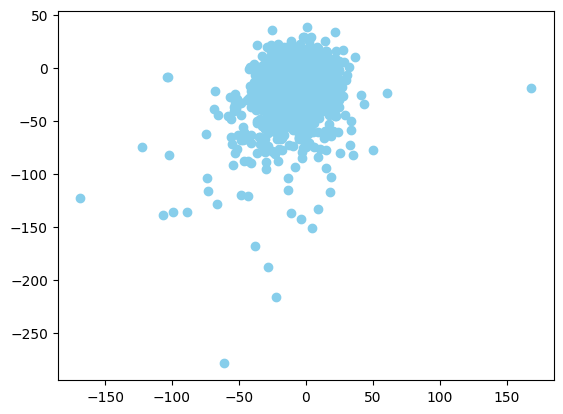

In [330]:

plt.scatter(gaia_df['pmra'], gaia_df['pmdec'], color='skyblue')
plt.show()

To me it seems like I got cluster inside cluster.

# 2. Isochrones

Recall that stellar clusters are gravitationally bound groupings of stars born at the same time.  By looking at the H-R diagram of a cluster -- specifically where the population _leaves_ the main sequence -- we can determine the age of the cluster.  To do this we must know the typical main sequence lifetime of stars, which depends on their mass, metalicity, etc. and for that we must turn to stellar modeling.  [MESA](https://docs.mesastar.org) is a stellar modeling library which incorporates the physics important for stellar evolution into 1-D models of stars.  The results useful for our purposes are stellar evolution tracks, the expected trajectory of the star through the H-R diagram as it evolves in time.

[MIST](http://waps.cfa.harvard.edu/MIST/index.html) is an effort to supply a large database of MESA stellar track simulations for the purpose of producing isochrones.  If you imagine stacking up a cluster's worth of stellar evolution tracks, slicing through them at fixed age will produce an isochrone.

I've used the [MIST isochrone interpolator](http://waps.cfa.harvard.edu/MIST/interp_isos.html) to produce an isochrone based on known properties of NGC 6397 (metalicity, reddening due to dust, etc.), and saved `BP-RP`, `Gaia_G_EDR3=phot_g_mean_mag` (with distance modulus already applied), and phase (indicating stellar evolutionary phase) to a CSV file, `data/NGC6397_iso.csv`.

1. Read in and plot the isochrone in all its messy glory.  Try encoding stellar phase information (e.g., using color) if you can, to get a better grasp on the various stellar phases we're looking at (remember, more info on what this indicates can be found [here](http://waps.cfa.harvard.edu/MIST/README_tables.pdf)).

In [331]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [332]:
iso_data = pd.read_csv('C:/Users/rabin/sci-comp-ii-fall24/Working/final_NGC-6397-project/data/NGC6397_iso.csv')
iso_data

,Unnamed: 0,bp_rp,Gaia_G_EDR3,phase
0,0,2.239831,24.494631,0.0
1,1,2.217666,24.409392,0.0
2,2,2.194527,24.315058,0.0
3,3,2.172080,24.221950,0.0
4,4,2.150091,24.129340,0.0
...,...,...,...,...
1447,1447,-0.087272,22.475614,6.0
1448,1448,-0.080667,22.519457,6.0
1449,1449,-0.074041,22.562334,6.0
1450,1450,-0.067388,22.604324,6.0


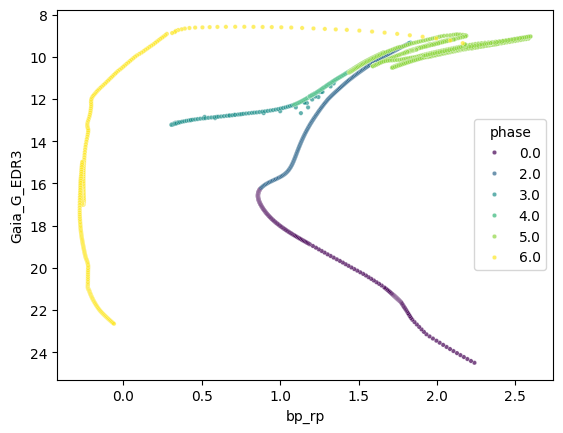

In [333]:
import seaborn as sns

sns.scatterplot(x=iso_data['bp_rp'], y=iso_data['Gaia_G_EDR3'], hue=iso_data['phase'], palette="viridis", s=10, alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis for magnitude

plt.show()

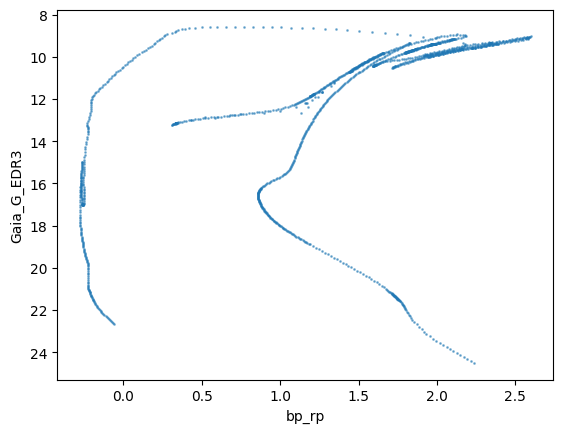

In [334]:
#H-R diagram

plt.scatter(iso_data.bp_rp, iso_data.Gaia_G_EDR3, s=1, alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel(r"bp_rp")
plt.ylabel('Gaia_G_EDR3')
# save limits for later use
xlim = plt.xlim()
ylim = plt.ylim()

2. Plot all of the Gaia data we pulled along with the isochrone.  In a new figure, plot the cluster members identified in `NGC6397-1.dat` with the isochrone.

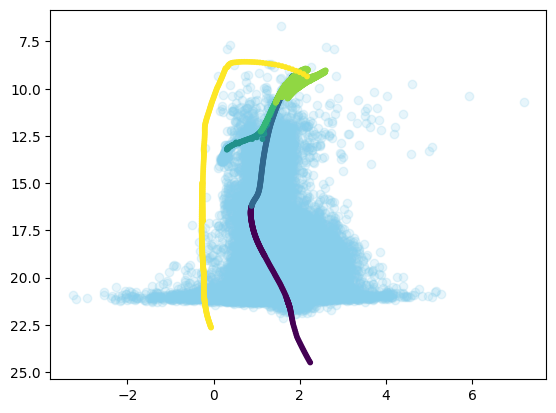

In [335]:

plt.scatter(gaia_df['bp_rp'], gaia_df['phot_g_mean_mag'], color='skyblue', alpha=0.2)
plt.scatter(iso_data['bp_rp'], iso_data['Gaia_G_EDR3'], c=iso_data['phase'], cmap='viridis', s=10)
plt.gca().invert_yaxis()

plt.show()

In [336]:
Cluster_df.columns

Index(['source_id', 'ra', 'dec', 'phot_g_mean_mag'], dtype='object')

In [337]:
Cluster_df

,source_id,ra,dec,phot_g_mean_mag
0,5921539825546549120,264.25211,-54.06070,19.086
1,5921542265088057472,264.20510,-53.94871,18.252
2,5921539585011442304,264.33958,-54.03101,19.001
3,5921530887707179136,264.28545,-54.20321,17.558
4,5921543192800960640,264.19193,-54.01173,19.580
...,...,...,...,...
22110,5921705714351627520,265.42989,-53.58280,19.074
22111,5921744605276401152,265.16443,-53.75388,13.111
22112,5921694478712334080,265.40734,-53.92330,19.691
22113,5921744403412609792,265.24265,-53.75581,18.204


In [338]:
iso_data.columns

Index(['Unnamed: 0', 'bp_rp', 'Gaia_G_EDR3', 'phase'], dtype='object')

In [339]:
iso_data

,Unnamed: 0,bp_rp,Gaia_G_EDR3,phase
0,0,2.239831,24.494631,0.0
1,1,2.217666,24.409392,0.0
2,2,2.194527,24.315058,0.0
3,3,2.172080,24.221950,0.0
4,4,2.150091,24.129340,0.0
...,...,...,...,...
1447,1447,-0.087272,22.475614,6.0
1448,1448,-0.080667,22.519457,6.0
1449,1449,-0.074041,22.562334,6.0
1450,1450,-0.067388,22.604324,6.0


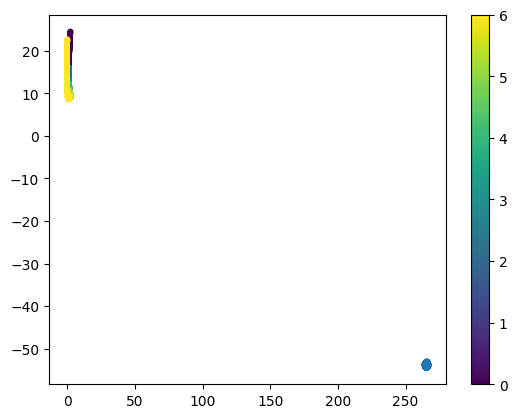

In [340]:
plt.scatter(Cluster_df['ra'], Cluster_df['dec'], label='Cluster', s=10)

plt.scatter(iso_data['bp_rp'], iso_data['Gaia_G_EDR3'], c=iso_data['phase'], cmap='viridis', s=10)

plt.colorbar()

plt.show()

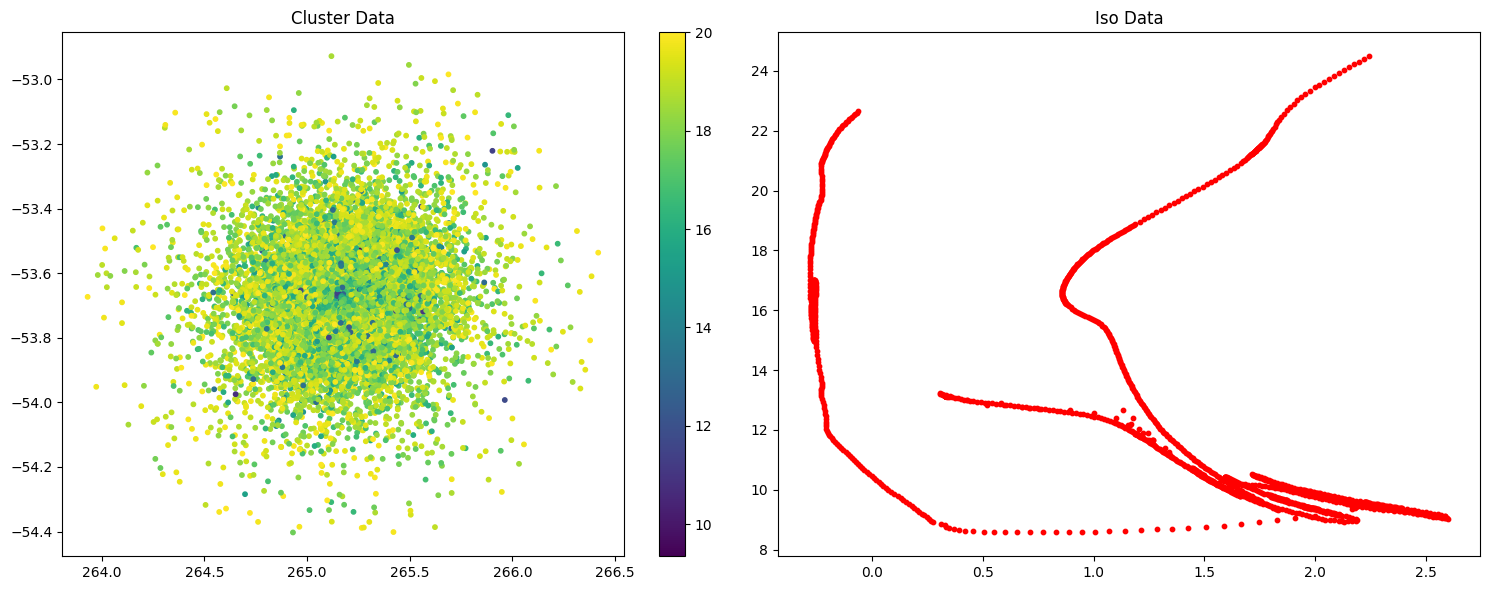

In [341]:
#I could not see anything useful while plotting cluster member with isochrone therefore I am plotting side by side.
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sc1 = axs[0].scatter(Cluster_df['ra'], Cluster_df['dec'], c=Cluster_df['phot_g_mean_mag'], cmap='viridis', s=10)
axs[0].set_title('Cluster Data')

fig.colorbar(sc1, ax=axs[0])

axs[1].scatter(iso_data['bp_rp'], iso_data['Gaia_G_EDR3'], c='red', s=10)
axs[1].set_title('Iso Data')

plt.tight_layout()
plt.show()

3. Use the isochrone to argue whether any new cluster candidates your classifier found are viable.

I am guessing we are referring new cluster candidates to the new members from previous section. 

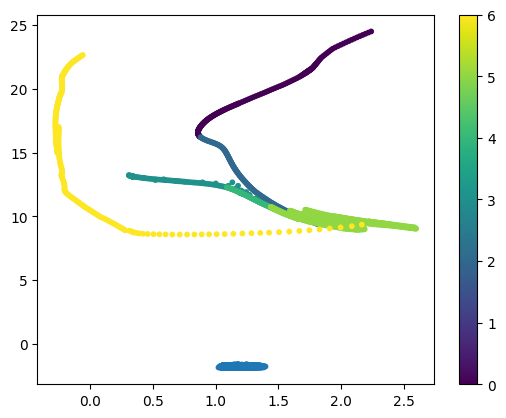

In [342]:
new_members = X_tst[pred == 1]  # stars predicted as cluster members

plt.scatter(new_members_df['pmra'], new_members_df['pmdec'], label='Cluster', s=10)

plt.scatter(iso_data['bp_rp'], iso_data['Gaia_G_EDR3'], c=iso_data['phase'], cmap='viridis', s=10)

plt.colorbar()

plt.show()

I had different features than what the isochrone columns have for cluster data, so I don't think they will overlap each other, but we can see the color bar shows the new cluster to be in a range of isochrones.

4. Now include color and brightness information in your model and retrain your classifier.  Does it perform any better?  Did you expect the outcome?

In [343]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [344]:
params = ['bp_rp', 'Gaia_G_EDR3']
X = np.array(iso_data[params])
X.shape

(1452, 2)

In [345]:
np.count_nonzero(np.any(np.isnan(X), axis=1))

0

In [346]:
nans = np.any(np.isnan(X), axis=1)
X = X[~nans]

n_classes = 2
#y = m4_sel.astype(int)[~nans]
y = iso_data['phase'].astype(int)[~nans]

In [347]:
from sklearn.preprocessing import StandardScaler

In [348]:
transformer = StandardScaler()

X = transformer.fit_transform(X)

In [349]:
m = X.shape[0]
test_frac = 0.1
test_sel = np.random.choice([True, False], size=m, p=[test_frac, 1-test_frac])
X_tst = X[test_sel]
X_train = X[~test_sel]

y_tst = y[test_sel]
y_train = y[~test_sel]

In [350]:
X_train = jnp.array(X_train)
X_tst = jnp.array(X_tst)
y_train = jnp.array(y_train)
y_tst = jnp.array(y_tst)

In [351]:
batch_size = 64
n_batches = X_train.shape[0] // batch_size

X_train = X_train[:n_batches * batch_size].reshape((n_batches, batch_size, *X_train.shape[1:]))
y_train = y_train[:n_batches * batch_size].reshape((n_batches, batch_size, *y_train.shape[1:]))
X_train.shape, y_train.shape

((20, 64, 2), (20, 64))

In [352]:
n_classes = 2

class DenseClassifier(nn.Module):
    """A simple dense classifier."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(n_classes)(x)
        return x   #every x is different

In [353]:
dummy_input = jnp.ones((1, 2))
dnn = DenseClassifier()
print(dnn.tabulate(jax.random.PRNGKey(0), dummy_input))


                            DenseClassifier Summary                            
┌─────────┬─────────────────┬───────────────┬───────────────┬─────────────────┐
│ path    │ module          │ inputs        │ outputs       │ params          │
├─────────┼─────────────────┼───────────────┼───────────────┼─────────────────┤
│         │ DenseClassifier │ float32[1,2]  │ float32[1,2]  │                 │
├─────────┼─────────────────┼───────────────┼───────────────┼─────────────────┤
│ Dense_0 │ Dense           │ float32[1,2]  │ float32[1,10] │ bias:           │
│         │                 │               │               │ float32[10]     │
│         │                 │               │               │ kernel:         │
│         │                 │               │               │ float32[2,10]   │
│         │                 │               │               │                 │
│         │                 │               │               │ 30 (120 B)      │
├─────────┼─────────────────┼──────────

In [354]:
X_train.shape, y_train.shape

((20, 64, 2), (20, 64))

In [355]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   metrics: Metrics

In [356]:
def create_train_state(model, rng, learning_rate):
    params = model.init(rng, dummy_input)['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=tx,
        metrics=Metrics.empty())

In [357]:
@jax.jit
def train_step(state, batch, label):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [358]:
@jax.jit
def compute_metrics(*, state, batch, label):
    logits = state.apply_fn({'params': state.params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=label, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [359]:
init_rng = jax.random.PRNGKey(0)

learning_rate = 0.01

state = create_train_state(dnn, init_rng, learning_rate)
del init_rng  # Must not be used anymore.

In [360]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [361]:
n_epochs = 50

In [362]:
step = 0

for _ in range(n_epochs):
  for batch, label in zip(X_train, y_train):

    # Run optimization steps over training batches and compute batch metrics
    state = train_step(state, batch, label) # get updated train state (which contains the updated parameters)
    state = compute_metrics(state=state, batch=batch, label=label) # aggregate batch metrics

    if (step+1) % n_batches == 0: # one training epoch has passed
      for metric,value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
      state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

      # Compute metrics on the test set after each training epoch
      test_state = state
      test_state = compute_metrics(state=test_state, batch=X_tst, label=y_tst)

      for metric,value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

      print(f"train epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
      print(f"test epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")
    step += 1

train epoch: 1, loss: nan, accuracy: 13.984375
test epoch: 1, loss: nan, accuracy: 11.347517013549805
train epoch: 2, loss: nan, accuracy: 13.984375
test epoch: 2, loss: nan, accuracy: 11.347517013549805
train epoch: 3, loss: nan, accuracy: 13.984375
test epoch: 3, loss: nan, accuracy: 11.347517013549805
train epoch: 4, loss: nan, accuracy: 13.984375
test epoch: 4, loss: nan, accuracy: 11.347517013549805
train epoch: 5, loss: nan, accuracy: 13.984375
test epoch: 5, loss: nan, accuracy: 11.347517013549805
train epoch: 6, loss: nan, accuracy: 13.984375
test epoch: 6, loss: nan, accuracy: 11.347517013549805
train epoch: 7, loss: nan, accuracy: 13.984375
test epoch: 7, loss: nan, accuracy: 11.347517013549805
train epoch: 8, loss: nan, accuracy: 13.984375
test epoch: 8, loss: nan, accuracy: 11.347517013549805
train epoch: 9, loss: nan, accuracy: 13.984375
test epoch: 9, loss: nan, accuracy: 11.347517013549805
train epoch: 10, loss: nan, accuracy: 13.984375
test epoch: 10, loss: nan, accurac

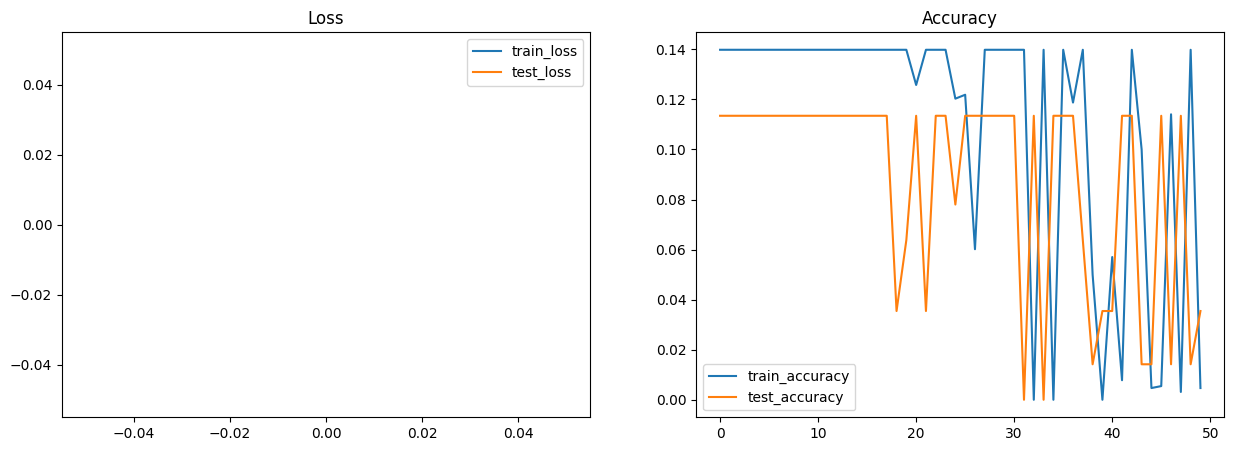

<Figure size 640x480 with 0 Axes>

In [363]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [364]:
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, batch)
  return logits.argmax(axis=1)

pred = pred_step(state, X_tst)
pred

Array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0], dtype=int32)

(array([  8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 133.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

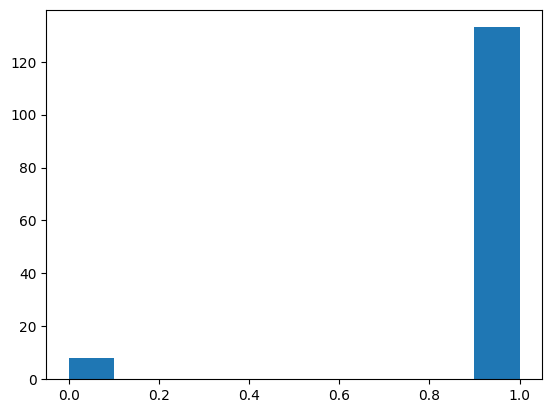

In [365]:
plt.hist(pred)

Prediction is >0 so we found some confident cluster members.

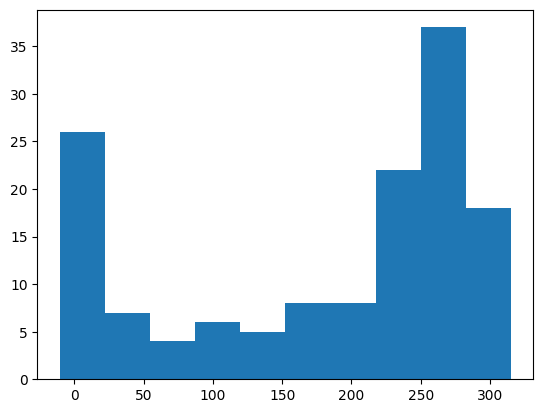

In [366]:
outputs = state.apply_fn({'params': state.params}, X_tst)
plt.hist(jnp.diff(outputs, axis=1).flatten());

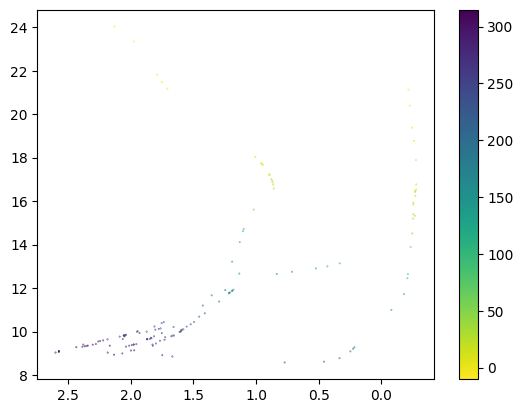

In [367]:
plt.scatter(iso_data.bp_rp[~nans][test_sel], iso_data.Gaia_G_EDR3[~nans][test_sel], c=jnp.diff(outputs, axis=1), s=.1, cmap='viridis_r')
plt.colorbar()

plt.gca().invert_xaxis()

As train accuracy and test accuracy are changing simultaneously, I suspect model is learning from overall data but the accuracy is not significant. I was expecting smooth graph but these spikes is making hard to read overall iterations.